# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc.

Our GAN uses from the folowing project, however our GAN network uses Fully Connected layers and No Convolutions layers:

-   Radford, Alec, Luke Metz, and Soumith Chintala. “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” ArXiv:1511.06434 [Cs], January 7, 2016. http://arxiv.org/abs/1511.06434

-------------
## Import necessary packages

In [14]:
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn
from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from typing import Set
from collections import namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [15]:
device = None
if torch.cuda.is_available():
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


-----
## Configuration
### Hyper parameters
Set up Hyper Parameters that our model needs.

We need to define several hyper parameters for our model:
1. Latent size
2. Hidden size
3. Input image size
4. Number of epochs
5. Batch size
6. Learning rate
7  Beta1 for ADAM Optimizer
8. Output Directory for generated images

In [16]:
class HyperParameter():
    def __init__(self,
                 latent_sz,
                 in_img_size,
                 in_img_channel=3,
                 data_dir="../data/img_align_celeba",
                 output_dir="../generated_imgs",
                 lr=0.0002,
                 beta1=0.5,
                 epochs=100,
                 batch_sz=64,
                 d_trained_wt_dir="../weights/discriminator_trained_weights",
                 g_trained_wt_dir="../weights/generator_trained_weights"):
        self.latent_size = latent_sz
        self.learning_rate = lr
        self.beta1 = beta1

        self.epochs = epochs
        self.batch_size = batch_sz
        self.input_img_channel = in_img_channel
        self.input_img_size = in_img_size

        self.discriminator_trained_weight_dir = d_trained_wt_dir
        self.generator_trained_weight_dir = g_trained_wt_dir
        self.output_dir = output_dir
        self.data_dir = data_dir

        os.makedirs(self.discriminator_trained_weight_dir, exist_ok=True)
        os.makedirs(self.generator_trained_weight_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)

    def __repr__(self):
        return f"latent_size: {self.latent_size}\n" + \
               f"learning_rate: {self.learning_rate}\n" + \
               f"beta1: {self.beta1}\n" + \
               f"input_img_size: {self.input_img_size}\n" + \
               f"input_img_channel: {self.input_img_channel}\n" + \
               f"epochs: {self.epochs}\n" + \
               f"batch_size: {self.batch_size}\n" + \
               f"data_dir: {self.data_dir}\n" + \
               f"output_dir: {self.output_dir}\n" + \
               f"discriminator_trained_weight_dir: {self.discriminator_trained_weight_dir}\n" + \
               f"generator_trained_weight_dir: {self.generator_trained_weight_dir}\n"

The **Hyper Parameter Class can be set up like so**

```python
hyper_parms = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, output_dir="../generated_imgs", lr=0.0002, beta1=0.5, epochs=100, batch_sz=64)
```

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Resize(64)


In [17]:
img_data_transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])  # Normalizes imgs in the range [-1,1]

-----
##  Data Loading
Next, we are going to load our data. 
### First, we need to prepare our data:
#### we use the following command to download our data:

```shell
$ apt-get install p7zip-full # ubuntu

$ brew install p7zip         # OSX

$ python download.py
```

-----
### Import the necessary library for data loading

In [18]:
import os.path
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm

import torch.utils.data as data
import torchvision.datasets as datasets
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

### We first define several helper functions that can help use to load each item in the dataset.

1.   We first create a list that contains all image files.    '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',.

2.   We define function `is_image_file()` which takes the file name as the input:
    <br />a. Return True if it is a valid image file else False
    
3.   We define `make_dataset()` function which takes a file path as the input:
    <br />a. Go over the path and find files
    <br />b. If it is a valid img file, store it to a list
    <br />c. Return the list
    
4.   Finally, create a function that is called default_loader()
    <br />a. that will open the image and convert it to the RGB using Image.open() and convert()

## Utility Functions

In [19]:
VALID_IMG_EXTENSIONS = {
    '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp',
    '.BMP'
}


def _is_image_file(fpath, valid_img_ext: Set = VALID_IMG_EXTENSIONS) -> bool:
    """Validates if a file is an img file"""
    _, img_ext = os.path.splitext(fpath)
    return img_ext in valid_img_ext


def make_img_dataset(root_dir, valid_img_ext: Set = VALID_IMG_EXTENSIONS):
    """Returns a list of valid img files after recursively chking in rootdir"""
    img_dataset = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if _is_image_file(file, valid_img_ext):
                img_path = os.path.join(subdir, file)
                img_dataset.append(img_path)

    return img_dataset


def default_loader(img):
    """Converts img file into RGB mode"""
    try:
        opened_img = Image.open(img)
        return opened_img.convert('RGB')
    except Exception as e:
        print(f"Exception: {e}. Skipping {img}")
        return False

### We then can use those helper functions to create our dataloader that load each item.  For this we creat a ImageDataset(data.Dataset) class

1. This function is initialized with root, train transform, target transform and loader
    <br /> a. We get all images using the utility functions we defined
    <br /> b. If there are no valid images we raise an proper error
    <br /> c. Print the length of valid data

2. We need to define a __getitem__() function that take index as input
    <br /> a. For the "index" element in the img list
         i.   Apply the transform
    <br /> b. Return the img and target.

3. We define a __len__() function that retrun the length of the dataset

In [20]:
class ImageDataset(Dataset):
    def __init__(self,
                 root_dir,
                 transform=None,
                 valid_img_ext: Set = VALID_IMG_EXTENSIONS):
        self.transform = transform

        self.face_dataset = make_img_dataset(root_dir, valid_img_ext)
        if len(self.face_dataset) == 0:
            raise IndexError("Face dataset is empty")

    def __len__(self):
        return len(self.face_dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.face_dataset[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image

### We then define our data loader get_loader()
#### This func has 5 arguments
1. root
2. batch size
3. scale size (img_data_transform)
4. number of workers
5. shuffle

<br /> We create a data_loader using torch.utils.data.DataLoader() with proper parameters

In [21]:
def get_data_loader(root_data_dir,
                    data_transform=img_data_transform,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True,
                    drop_last=True):
    """
    root_dir is the directory with the images
    """
    face_dataset = ImageDataset(root_data_dir, data_transform)
    data_loader = torch.utils.data.DataLoader(face_dataset,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              shuffle=shuffle,
                                              drop_last=True)
    return data_loader

Then, we use the function above to load the data to data_loader variables which will be called before training our GAN

```python
train_data_loader = get_data_loader(hyper_parms.data_dir, batch_size=hyper_parms.batch_size, num_workers=5)
```

-----
##  Network

To design our GAN network, we use `nn.Sequential()` to stack several layers and activation functions

### First, we create our Discriminator

1. We use one Input layer, one Hidden layer and one Output layer. All of them are defined using nn.Linear() with proper input dim and out dim

2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 

3. We use nn.Sigmoid() activation function for the output layer

### Next, we make our Generator 

1. We need one Input layer, two Hidden layers and one Output layer. All of them are defined using nn.Linear() with proper input and output dimension

2. We use nn.ReLU() as activation functions for the Input and Hidden layer. 

3. We use nn.Tanh() as activation function for the Output layer

## Discriminator

####  Structure of the Discriminator module as follow:

1.	The input of the first linear layer is the image size (64), output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the LeakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the LeakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_img_size=64, in_img_channels=3, n_gpu=1):
        super(Discriminator, self).__init__()
        self.n_gpu = n_gpu

        self.main = nn.Sequential(
            # Input size is input_img_size*input_img_size*3 (img_width, img_height, input_img_channels)
            nn.Linear(in_img_size * in_img_size * in_img_channels, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid())

    def forward(self, X):
        if X.is_cuda and self.n_gpu > 1:
            output = nn.parallel.data_parallel(self.main, X, range(self.n_gpu))
        else:
            output = self.main(X)
        return output

## Generator 

#### Structure of the Generator module as follow:

1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.


In [23]:
class Generator(nn.Module):
    def __init__(self,
                 latent_vector_size,
                 in_img_size=64,
                 in_img_channels=3,
                 n_gpu=1):
        super(Generator, self).__init__()
        self.n_gpu = n_gpu

        self.main = nn.Sequential(
            # laten vector reprs the latent space
            nn.Linear(latent_vector_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, in_img_size * in_img_size * in_img_channels),
            nn.Tanh())

    def forward(self, X):
        if X.is_cuda and self.n_gpu > 1:
            output = nn.parallel.data_parallel(self.main, X, range(self.n_gpu))
        else:
            output = self.main(X)
        return output

## GAN 

In [24]:
class GAN():
    """
    GAN Class with fit method that trains the GAN
    """
    def __init__(self,
                 hyper_parameter,
                 load_wt=True,
                 save_wt=True,
                 save_wt_interval=10,
                 save_img_interval=50):
        self.hp = hyper_parameter
        self.G_net = Generator(self.hp.latent_size,
                               self.hp.input_img_size).to(device)
        self.D_net = Discriminator(self.hp.input_img_size).to(device)
        self.D_loss_overtime = []
        self.G_loss_overtime = []

        if load_wt: self._load_saved_weights()
        # Binary Cross Entropy Loss
        self.criterion = nn.BCELoss()

        # Optimizers
        self.G_optimizer = torch.optim.Adam(self.G_net.parameters(),
                                            lr=self.hp.learning_rate,
                                            betas=(self.hp.beta1, 0.999))
        self.D_optimizer = torch.optim.Adam(self.D_net.parameters(),
                                            lr=self.hp.learning_rate,
                                            betas=(self.hp.beta1, 0.999))

    def _load_saved_weights(self):
        D_weight_files = glob(self.hp.discriminator_trained_weight_dir +
                              '/*.pt')
        if D_weight_files:
            latest_D_wt = max(D_weight_files, key=os.path.getctime)
            print(f"Loading weight {latest_D_wt} for Discriminator")
            self.D_net.load_state_dict(torch.load(latest_D_wt))
            self.D_net.eval()

        G_weight_files = glob(self.hp.generator_trained_weight_dir + '/*.pt')
        if G_weight_files:
            latest_G_wt = max(G_weight_files, key=os.path.getctime)
            print(f"Loading weight {latest_G_wt} for Generator")
            self.G_net.load_state_dict(torch.load(latest_G_wt))
            self.G_net.eval()

    @staticmethod
    def denorm(X):
        """ This is the denorm when norm is done with transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"""
        out = (X + 1) / 2
        return out.clamp(0, 1)

    @staticmethod
    def plot_gan_loss(G_loss, D_loss, save_dir="../loss_curves"):
        plt.plot(G_loss, label='Generator Loss')
        plt.plot(D_loss, label='Discriminator Loss')
        plt.title("GAN Loss")
        plt.ylabel("BCE Loss")
        plt.xlabel("Iterations (x10)")
        plt.legend()

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{time.time()}_GAN_loss.png")
        plt.show()

    def plot_loss(self):
        GAN.plot_gan_loss(self.G_loss_overtime, self.D_loss_overtime)

    def fit(self,
            train_data_loader,
            save_wt=True,
            save_img_interval=50,
            save_wt_interval=10):
        # Generator uses this noise to generate the images in the dataset for benchmarking
        fixed_noise = torch.randn(self.hp.batch_size,
                                  self.hp.latent_size,
                                  device=device)

        for epoch in tqdm(range(self.hp.epochs)):
            d_running_loss, g_running_loss = 0, 0

            # mini-batch training
            for idx, data in enumerate(train_data_loader):
                # set to (64, -1) -1 should be equi to img_sz * img_sz * img_ch
                X_data = data.reshape(self.hp.batch_size, -1)
                X_data = X_data.to(device)

                # real_label = 1, fake_label = 0
                real_labels = torch.ones(self.hp.batch_size, 1).to(device)
                fake_labels = torch.zeros(self.hp.batch_size, 1).to(device)

                ### Train Discriminator which maximizes log(D(x)) + log(1 - D(G(z))) ###
                # Using real images
                self.D_net.zero_grad()
                D_real_output = self.D_net(X_data)  # feedforward
                D_real_loss = self.criterion(D_real_output,
                                             real_labels)  # cal loss
                D_real_loss.backward()

                # Using fake images
                noise = torch.randn(self.hp.batch_size,
                                    self.hp.latent_size,
                                    device=device)
                G_fake_output = self.G_net(noise)  # feedforward
                D_fake_output = self.D_net(G_fake_output.detach())
                D_fake_loss = self.criterion(D_fake_output, fake_labels)
                D_fake_loss.backward()

                D_loss = D_real_loss + D_fake_loss
                self.D_optimizer.step()

                ### Train Generator which maximizes log(D(G(z))) as Gradient Descent is expensive ###
                self.G_net.zero_grad()
                G_output = self.D_net(G_fake_output)
                G_loss = self.criterion(G_output, real_labels)
                G_loss.backward()
                self.G_optimizer.step()

                d_running_loss += D_loss.item()
                g_running_loss += G_loss.item()
                fmt_epoch = "{:04d}".format(epoch)
                fmt_idx = "{:04d}".format(idx)

                if idx % save_img_interval == 0:
                    # Real image
                    torchvision.utils.save_image(
                        data,
                        f'{self.hp.output_dir}/{fmt_epoch}_{fmt_idx}_real_samples.png',
                        normalize=True)
                    # Generated fake image
                    fake_gen = self.G_net(fixed_noise)
                    fake_gen = GAN.denorm(
                        fake_gen.reshape(self.hp.batch_size, 3,
                                         self.hp.input_img_size,
                                         self.hp.input_img_size))
                    torchvision.utils.save_image(
                        fake_gen,
                        f'{self.hp.output_dir}/{fmt_epoch}_{fmt_idx}_fake_samples.png',
                        normalize=True)

                if idx % 20 == 0:
                    print(
                        f"Discriminator Loss at epoch: {epoch}, iter {idx} = {D_loss.item()}"
                    )
                    print(
                        f"Generator Loss at epoch: {epoch}, iter {idx} = {G_loss.item()}"
                    )

                    d_avg_running_loss = d_running_loss / max(1, idx)
                    g_avg_running_loss = g_running_loss / max(1, idx)
                    self.D_loss_overtime.append(d_avg_running_loss)
                    self.G_loss_overtime.append(g_avg_running_loss)

                # Save checkpoint weights
                if save_wt and idx % save_wt_interval == 0:
                    torch.save(
                        self.D_net.state_dict(),
                        self.hp.discriminator_trained_weight_dir +
                        f'/dnet_epoch_{fmt_epoch}_iter_{fmt_idx}.pt')
                    torch.save(
                        self.G_net.state_dict(),
                        self.hp.generator_trained_weight_dir +
                        f'/gnet_epoch_{fmt_epoch}_iter_{fmt_idx}.pt')

________

# GAN TRAIN SECTION

First we break down the `GAN.fit(...)` method and run functions one after another
________

In [25]:
hyper_parms = HyperParameter(latent_sz=100,
                             in_img_size=64,
                             in_img_channel=3,
                             output_dir="../latestgenerated_imgs",
                             lr=0.0002,
                             beta1=0.5,
                             epochs=100,
                             batch_sz=64)

### Next, we send the network to the target device

In [26]:
G_net = Generator(hyper_parms.latent_size,
                  hyper_parms.input_img_size).to(device)
D_net = Discriminator(hyper_parms.input_img_size).to(device)

### Load saved weights for the Generator and the Discriminator if they are available

In [27]:
D_weight_files = glob(hyper_parms.discriminator_trained_weight_dir + '/*.pt')
if D_weight_files:
    latest_D_wt = max(D_weight_files, key=os.path.getctime)
    print(f"Loading weight {latest_D_wt} for Discriminator")
    D_net.load_state_dict(torch.load(latest_D_wt))
    D_net.eval()

G_weight_files = glob(hyper_parms.generator_trained_weight_dir + '/*.pt')
if G_weight_files:
    latest_G_wt = max(G_weight_files, key=os.path.getctime)
    G_net.load_state_dict(torch.load(latest_G_wt))
    print(f"Loading weight {latest_G_wt} for Generator")
    G_net.eval()

Loading weight ../discriminator_trained_weights/dnet_epoch_9_iter_1750.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_epoch_9_iter_1750.pt for Generator


### Set the Loss function and Optimizer with proper netwrok parameters and learning rates

-   Binary Cross Entropy Loss
-   ADAM Optimizer

In [28]:
# Loss
criterion = nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G_net.parameters(),
                               lr=hyper_parms.learning_rate,
                               betas=(hyper_parms.beta1, 0.999))
D_optimizer = torch.optim.Adam(D_net.parameters(),
                               lr=hyper_parms.learning_rate,
                               betas=(hyper_parms.beta1, 0.999))

# Generator uses this noise to generate the images in the dataset for benchmarking
fixed_noise = torch.randn(hyper_parms.batch_size,
                          hyper_parms.latent_size,
                          device=device)

-----
##  Training

### Helper Function

1. Denorm function using clamp() api from pytorch https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp

In [29]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### Training
1. Store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. Reshape the input data to (batch_size，-1) and send to the proper device
        ii. Then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. Then we train the descriminator
            A. Feedforward and store the predictions of discriminator
            B. Compute BCE_Loss using real images and store the loss
            C. Random init a latent code z
            D. Feedforward and store the predictions of generator
            E. Feed the predictions to the descriminator and store the prediction
            F. Compute BCELoss using fake images and store the loss
            G. Backprop the losses after reseting the optimizer gradients
        iv. Then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. Feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perform the backprop using losses after that reset the gradient of optimizer.
        v. After some epochs/iterations, we print logs with proper info
        
    <br/> b. We store all real image batches with shape (batch_size, 3, img_size, img_size) inoder for the further comparision only once
    <br/> c. We save the fake image batches with image shape (batch_size, 3, img_size, img_size) and denorm() function 
3. Save the model checkpoints using torch.save()


In [30]:
hyper_parms

latent_size: 100
learning_rate: 0.0002
beta1: 0.5
input_img_size: 64
input_img_channel: 3
epochs: 100
batch_size: 64
data_dir: ../data/img_align_celeba
output_dir: ../latestgenerated_imgs
discriminator_trained_weight_dir: ../discriminator_trained_weights
generator_trained_weight_dir: ../generator_trained_weights

In [ ]:
DEBUG = False
D_loss_overtime, G_loss_overtime = [], []
save_weights = True
save_weight_interval = 10
save_img_interval = 50
data_loader = get_data_loader("../mini_data/")

for epoch in tqdm(range(hyper_parms.epochs)):
    d_running_loss, g_running_loss = 0, 0

    # mini-batch training
    for idx, data in enumerate(data_loader):
        # set to (64, -1) -1 should be equi to img_sz * img_sz * img_ch
        X_data = data.reshape(hyper_parms.batch_size, -1)
        X_data = X_data.to(device)

        # real_label = 1, fake_label = 0
        real_labels = torch.ones(hyper_parms.batch_size, 1).to(device)
        fake_labels = torch.zeros(hyper_parms.batch_size, 1).to(device)

        ### Train Discriminator which maximizes log(D(x)) + log(1 - D(G(z))) ###
        # Using real images
        D_net.zero_grad()
        D_real_output = D_net(X_data)  # feedforward
        D_real_loss = criterion(D_real_output, real_labels)  # cal loss
        D_real_loss.backward()

        # Using fake images
        noise = torch.randn(hyper_parms.batch_size,
                            hyper_parms.latent_size,
                            device=device)
        G_fake_output = G_net(noise)  # feedforward
        D_fake_output = D_net(G_fake_output.detach())
        D_fake_loss = criterion(D_fake_output, fake_labels)
        D_fake_loss.backward()

        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()

        ### Train Generator which maximizes log(D(G(z))) as Gradient Descent is expensive ###
        G_net.zero_grad()
        G_output = D_net(G_fake_output)
        G_loss = criterion(G_output, real_labels)
        G_loss.backward()
        G_optimizer.step()

        d_running_loss += D_loss.item()
        g_running_loss += G_loss.item()
        fmt_epoch = "{:04d}".format(epoch)
        fmt_idx = "{:04d}".format(idx)

        if idx % save_img_interval == 0:
            # Real image
            torchvision.utils.save_image(
                data,
                f'{hyper_parms.output_dir}/{fmt_epoch}_{fmt_idx}_real_samples.png',
                normalize=True)
            # Generated fake image
            fake_gen = G_net(fixed_noise)
            fake_gen = denorm(
                fake_gen.reshape(hyper_parms.batch_size, 3,
                                 hyper_parms.input_img_size,
                                 hyper_parms.input_img_size))
            torchvision.utils.save_image(
                fake_gen,
                f'{hyper_parms.output_dir}/{fmt_epoch}_{fmt_idx}_fake_samples.png',
                normalize=True)

        if idx % 20 == 0:
            print(
                f"Discriminator Loss at epoch: {epoch}, iter {idx} = {D_loss.item()}"
            )
            print(
                f"Generator Loss at epoch: {epoch}, iter {idx} = {G_loss.item()}"
            )

            d_avg_running_loss = d_running_loss / max(1, idx)
            g_avg_running_loss = g_running_loss / max(1, idx)
            D_loss_overtime.append(d_avg_running_loss)
            G_loss_overtime.append(g_avg_running_loss)

        # Save checkpoint weights
        if save_weights and epoch % save_weight_interval == 0:
            torch.save(
                D_net.state_dict(),
                hyper_parms.discriminator_trained_weight_dir +
                f'/dnet_epoch_{fmt_epoch}_iter_{fmt_idx}.pt')
            torch.save(
                G_net.state_dict(),
                hyper_parms.generator_trained_weight_dir + 
                f'/gnet_epoch_{fmt_epoch}_iter_{fmt_idx}.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 1.3257914781570435
Generator Loss at epoch: 0, iter 0 = 0.8346496224403381


  2%|▏         | 2/100 [00:04<04:04,  2.49s/it]

Discriminator Loss at epoch: 1, iter 0 = 1.2147197723388672
Generator Loss at epoch: 1, iter 0 = 0.9148199558258057


  3%|▎         | 3/100 [00:05<03:19,  2.06s/it]

Discriminator Loss at epoch: 2, iter 0 = 1.2867521047592163
Generator Loss at epoch: 2, iter 0 = 0.8181997537612915


  4%|▍         | 4/100 [00:06<02:58,  1.86s/it]

Discriminator Loss at epoch: 3, iter 0 = 1.2235809564590454
Generator Loss at epoch: 3, iter 0 = 0.8619502186775208


  5%|▌         | 5/100 [00:09<03:12,  2.02s/it]

Discriminator Loss at epoch: 4, iter 0 = 1.142781138420105
Generator Loss at epoch: 4, iter 0 = 0.9364144802093506


  6%|▌         | 6/100 [00:10<02:47,  1.78s/it]

Discriminator Loss at epoch: 5, iter 0 = 1.0960896015167236
Generator Loss at epoch: 5, iter 0 = 0.9810068607330322


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

Discriminator Loss at epoch: 6, iter 0 = 1.1088224649429321
Generator Loss at epoch: 6, iter 0 = 0.9580832719802856


  8%|▊         | 8/100 [00:13<02:26,  1.59s/it]

Discriminator Loss at epoch: 7, iter 0 = 1.0548018217086792
Generator Loss at epoch: 7, iter 0 = 1.0011403560638428


  9%|▉         | 9/100 [00:15<02:53,  1.91s/it]

Discriminator Loss at epoch: 8, iter 0 = 1.0158321857452393
Generator Loss at epoch: 8, iter 0 = 0.9954937696456909


 10%|█         | 10/100 [00:16<02:28,  1.65s/it]

Discriminator Loss at epoch: 9, iter 0 = 0.9912300109863281
Generator Loss at epoch: 9, iter 0 = 1.0269383192062378
Discriminator Loss at epoch: 10, iter 0 = 0.9836949110031128
Generator Loss at epoch: 10, iter 0 = 1.091097354888916


 12%|█▏        | 12/100 [00:20<02:38,  1.80s/it]

Discriminator Loss at epoch: 11, iter 0 = 0.9668639302253723
Generator Loss at epoch: 11, iter 0 = 1.0824030637741089


 13%|█▎        | 13/100 [00:23<03:00,  2.07s/it]

Discriminator Loss at epoch: 12, iter 0 = 0.9641678333282471
Generator Loss at epoch: 12, iter 0 = 1.1020069122314453


 14%|█▍        | 14/100 [00:24<02:32,  1.77s/it]

Discriminator Loss at epoch: 13, iter 0 = 0.9248948097229004
Generator Loss at epoch: 13, iter 0 = 1.167647123336792


 15%|█▌        | 15/100 [00:25<02:13,  1.58s/it]

Discriminator Loss at epoch: 14, iter 0 = 0.8835282921791077
Generator Loss at epoch: 14, iter 0 = 1.2165756225585938


 16%|█▌        | 16/100 [00:27<02:05,  1.50s/it]

Discriminator Loss at epoch: 15, iter 0 = 0.8637958765029907
Generator Loss at epoch: 15, iter 0 = 1.1972601413726807


 17%|█▋        | 17/100 [00:29<02:27,  1.77s/it]

Discriminator Loss at epoch: 16, iter 0 = 0.8864328861236572
Generator Loss at epoch: 16, iter 0 = 1.138922929763794


 18%|█▊        | 18/100 [00:30<02:12,  1.61s/it]

Discriminator Loss at epoch: 17, iter 0 = 0.8553178906440735
Generator Loss at epoch: 17, iter 0 = 1.180738925933838


 19%|█▉        | 19/100 [00:31<01:56,  1.43s/it]

Discriminator Loss at epoch: 18, iter 0 = 0.9175482988357544
Generator Loss at epoch: 18, iter 0 = 1.1873100996017456


 20%|██        | 20/100 [00:32<01:47,  1.34s/it]

Discriminator Loss at epoch: 19, iter 0 = 0.8326940536499023
Generator Loss at epoch: 19, iter 0 = 1.2531999349594116
Discriminator Loss at epoch: 20, iter 0 = 0.8298884034156799
Generator Loss at epoch: 20, iter 0 = 1.2481331825256348


 22%|██▏       | 22/100 [00:38<02:34,  1.98s/it]

Discriminator Loss at epoch: 21, iter 0 = 0.8824440836906433
Generator Loss at epoch: 21, iter 0 = 1.1576240062713623


 23%|██▎       | 23/100 [00:39<02:11,  1.70s/it]

Discriminator Loss at epoch: 22, iter 0 = 0.8574748039245605
Generator Loss at epoch: 22, iter 0 = 1.275324821472168


 24%|██▍       | 24/100 [00:40<01:59,  1.57s/it]

Discriminator Loss at epoch: 23, iter 0 = 0.8776691555976868
Generator Loss at epoch: 23, iter 0 = 1.2683610916137695


 25%|██▌       | 25/100 [00:41<01:46,  1.41s/it]

Discriminator Loss at epoch: 24, iter 0 = 0.7888699173927307
Generator Loss at epoch: 24, iter 0 = 1.3327516317367554


 26%|██▌       | 26/100 [00:45<02:29,  2.03s/it]

Discriminator Loss at epoch: 25, iter 0 = 0.8059048652648926
Generator Loss at epoch: 25, iter 0 = 1.2763923406600952


 27%|██▋       | 27/100 [00:46<02:09,  1.78s/it]

Discriminator Loss at epoch: 26, iter 0 = 0.7947536706924438
Generator Loss at epoch: 26, iter 0 = 1.2923810482025146


 28%|██▊       | 28/100 [00:47<01:54,  1.60s/it]

Discriminator Loss at epoch: 27, iter 0 = 0.7995351552963257
Generator Loss at epoch: 27, iter 0 = 1.267259955406189


 29%|██▉       | 29/100 [00:48<01:41,  1.43s/it]

Discriminator Loss at epoch: 28, iter 0 = 0.7956447601318359
Generator Loss at epoch: 28, iter 0 = 1.3212770223617554


 30%|███       | 30/100 [00:51<02:03,  1.76s/it]

Discriminator Loss at epoch: 29, iter 0 = 0.7475034594535828
Generator Loss at epoch: 29, iter 0 = 1.3767213821411133
Discriminator Loss at epoch: 30, iter 0 = 0.7726170420646667
Generator Loss at epoch: 30, iter 0 = 1.3004965782165527


 32%|███▏      | 32/100 [00:55<02:04,  1.83s/it]

Discriminator Loss at epoch: 31, iter 0 = 0.744907796382904
Generator Loss at epoch: 31, iter 0 = 1.3595030307769775


 33%|███▎      | 33/100 [00:56<01:49,  1.64s/it]

Discriminator Loss at epoch: 32, iter 0 = 0.7780149579048157
Generator Loss at epoch: 32, iter 0 = 1.3337839841842651


 34%|███▍      | 34/100 [00:59<02:09,  1.96s/it]

Discriminator Loss at epoch: 33, iter 0 = 0.7163040041923523
Generator Loss at epoch: 33, iter 0 = 1.457470178604126


 35%|███▌      | 35/100 [01:00<01:52,  1.73s/it]

Discriminator Loss at epoch: 34, iter 0 = 0.6722465753555298
Generator Loss at epoch: 34, iter 0 = 1.4397534132003784


 36%|███▌      | 36/100 [01:01<01:39,  1.55s/it]

Discriminator Loss at epoch: 35, iter 0 = 0.6709060668945312
Generator Loss at epoch: 35, iter 0 = 1.4813183546066284


 37%|███▋      | 37/100 [01:02<01:33,  1.48s/it]

Discriminator Loss at epoch: 36, iter 0 = 0.6849151849746704
Generator Loss at epoch: 36, iter 0 = 1.440121054649353


 38%|███▊      | 38/100 [01:04<01:26,  1.39s/it]

Discriminator Loss at epoch: 37, iter 0 = 0.6993526220321655
Generator Loss at epoch: 37, iter 0 = 1.4646483659744263


 39%|███▉      | 39/100 [01:06<01:45,  1.73s/it]

Discriminator Loss at epoch: 38, iter 0 = 0.650520920753479
Generator Loss at epoch: 38, iter 0 = 1.6037169694900513


 40%|████      | 40/100 [01:07<01:31,  1.52s/it]

Discriminator Loss at epoch: 39, iter 0 = 0.6336826086044312
Generator Loss at epoch: 39, iter 0 = 1.5052906274795532
Discriminator Loss at epoch: 40, iter 0 = 0.637959361076355
Generator Loss at epoch: 40, iter 0 = 1.4634394645690918


 42%|████▏     | 42/100 [01:11<01:36,  1.67s/it]

Discriminator Loss at epoch: 41, iter 0 = 0.627998411655426
Generator Loss at epoch: 41, iter 0 = 1.4522733688354492


 43%|████▎     | 43/100 [01:14<01:53,  2.00s/it]

Discriminator Loss at epoch: 42, iter 0 = 0.602905809879303
Generator Loss at epoch: 42, iter 0 = 1.517993450164795


 44%|████▍     | 44/100 [01:15<01:43,  1.85s/it]

Discriminator Loss at epoch: 43, iter 0 = 0.6511296033859253
Generator Loss at epoch: 43, iter 0 = 1.4821484088897705


 45%|████▌     | 45/100 [01:17<01:31,  1.66s/it]

Discriminator Loss at epoch: 44, iter 0 = 0.6488348245620728
Generator Loss at epoch: 44, iter 0 = 1.4536046981811523


 46%|████▌     | 46/100 [01:18<01:20,  1.49s/it]

Discriminator Loss at epoch: 45, iter 0 = 0.6536548137664795
Generator Loss at epoch: 45, iter 0 = 1.4274263381958008


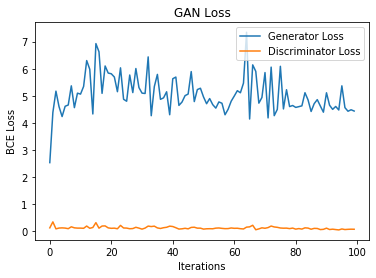

In [25]:
GAN.plot_gan_loss(G_loss_overtime, D_loss_overtime)

## Training our model on the small dataset with our GAN class

In [33]:
hp1 = HyperParameter(latent_sz=100,
                     in_img_size=64,
                     in_img_channel=3,
                     output_dir="../generated_imgs",
                     lr=0.0002,
                     beta1=0.5,
                     epochs=100,
                     batch_sz=64)
small_dataset = get_data_loader("../mini_data/")
g1 = GAN(hp1)
g1.fit(small_dataset)

Loading weight ../discriminator_trained_weights/dnet_90.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_90.pt for Generator


  0%|          | 0/100 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 0.3387264609336853
Generator Loss at epoch: 0, iter 0 = 1.761309027671814


  1%|          | 1/100 [00:04<07:24,  4.49s/it]

Discriminator Loss at epoch: 1, iter 0 = 0.32058951258659363
Generator Loss at epoch: 1, iter 0 = 1.7399402856826782


  2%|▏         | 2/100 [00:07<06:34,  4.02s/it]

Discriminator Loss at epoch: 2, iter 0 = 0.32851409912109375
Generator Loss at epoch: 2, iter 0 = 1.750800371170044


  3%|▎         | 3/100 [00:10<06:02,  3.74s/it]

Discriminator Loss at epoch: 3, iter 0 = 0.34140950441360474
Generator Loss at epoch: 3, iter 0 = 1.8014144897460938


  4%|▍         | 4/100 [00:14<06:15,  3.91s/it]

Discriminator Loss at epoch: 4, iter 0 = 0.2930857241153717
Generator Loss at epoch: 4, iter 0 = 1.869510293006897


  5%|▌         | 5/100 [00:17<05:43,  3.62s/it]

Discriminator Loss at epoch: 5, iter 0 = 0.3075293302536011
Generator Loss at epoch: 5, iter 0 = 1.7259342670440674


  6%|▌         | 6/100 [00:20<05:21,  3.42s/it]

Discriminator Loss at epoch: 6, iter 0 = 0.2712128460407257
Generator Loss at epoch: 6, iter 0 = 1.854814052581787


  7%|▋         | 7/100 [00:24<05:24,  3.49s/it]

Discriminator Loss at epoch: 7, iter 0 = 0.273418128490448
Generator Loss at epoch: 7, iter 0 = 1.9086856842041016


  8%|▊         | 8/100 [00:28<05:49,  3.80s/it]

Discriminator Loss at epoch: 8, iter 0 = 0.2608705163002014
Generator Loss at epoch: 8, iter 0 = 2.0153648853302


  9%|▉         | 9/100 [00:31<05:21,  3.53s/it]

Discriminator Loss at epoch: 9, iter 0 = 0.2544597387313843
Generator Loss at epoch: 9, iter 0 = 1.922121286392212


 10%|█         | 10/100 [00:34<04:58,  3.32s/it]

Discriminator Loss at epoch: 10, iter 0 = 0.2604232132434845
Generator Loss at epoch: 10, iter 0 = 1.9297624826431274


 11%|█         | 11/100 [00:39<05:28,  3.69s/it]

Discriminator Loss at epoch: 11, iter 0 = 0.240474134683609
Generator Loss at epoch: 11, iter 0 = 2.00431489944458


 12%|█▏        | 12/100 [00:42<05:06,  3.48s/it]

Discriminator Loss at epoch: 12, iter 0 = 0.2530818581581116
Generator Loss at epoch: 12, iter 0 = 1.9385063648223877


 13%|█▎        | 13/100 [00:44<04:45,  3.28s/it]

Discriminator Loss at epoch: 13, iter 0 = 0.22598899900913239
Generator Loss at epoch: 13, iter 0 = 2.109907627105713


 14%|█▍        | 14/100 [00:48<04:46,  3.33s/it]

Discriminator Loss at epoch: 14, iter 0 = 0.21447914838790894
Generator Loss at epoch: 14, iter 0 = 2.099698543548584


 15%|█▌        | 15/100 [00:52<04:56,  3.49s/it]

Discriminator Loss at epoch: 15, iter 0 = 0.2400520145893097
Generator Loss at epoch: 15, iter 0 = 1.9834315776824951


 16%|█▌        | 16/100 [00:55<04:40,  3.34s/it]

Discriminator Loss at epoch: 16, iter 0 = 0.21687181293964386
Generator Loss at epoch: 16, iter 0 = 2.1127467155456543


 17%|█▋        | 17/100 [00:58<04:39,  3.37s/it]

Discriminator Loss at epoch: 17, iter 0 = 0.23471015691757202
Generator Loss at epoch: 17, iter 0 = 2.273820400238037


 18%|█▊        | 18/100 [01:03<05:04,  3.71s/it]

Discriminator Loss at epoch: 18, iter 0 = 0.2297256886959076
Generator Loss at epoch: 18, iter 0 = 1.9694828987121582


 19%|█▉        | 19/100 [01:06<04:38,  3.44s/it]

Discriminator Loss at epoch: 19, iter 0 = 0.20322653651237488
Generator Loss at epoch: 19, iter 0 = 2.0306003093719482


 20%|██        | 20/100 [01:09<04:25,  3.32s/it]

Discriminator Loss at epoch: 20, iter 0 = 0.22182637453079224
Generator Loss at epoch: 20, iter 0 = 2.189563274383545


 21%|██        | 21/100 [01:13<04:51,  3.69s/it]

Discriminator Loss at epoch: 21, iter 0 = 0.2029937207698822
Generator Loss at epoch: 21, iter 0 = 2.281770706176758


 22%|██▏       | 22/100 [01:16<04:28,  3.44s/it]

Discriminator Loss at epoch: 22, iter 0 = 0.23477911949157715
Generator Loss at epoch: 22, iter 0 = 2.3016161918640137


 23%|██▎       | 23/100 [01:19<04:14,  3.31s/it]

Discriminator Loss at epoch: 23, iter 0 = 0.21790196001529694
Generator Loss at epoch: 23, iter 0 = 2.095824718475342


 24%|██▍       | 24/100 [01:22<04:05,  3.24s/it]

Discriminator Loss at epoch: 24, iter 0 = 0.2302848994731903
Generator Loss at epoch: 24, iter 0 = 2.0922608375549316


 25%|██▌       | 25/100 [01:27<04:46,  3.82s/it]

Discriminator Loss at epoch: 25, iter 0 = 0.21094194054603577
Generator Loss at epoch: 25, iter 0 = 2.215606212615967


 26%|██▌       | 26/100 [01:30<04:22,  3.55s/it]

Discriminator Loss at epoch: 26, iter 0 = 0.21102496981620789
Generator Loss at epoch: 26, iter 0 = 2.186311721801758


 27%|██▋       | 27/100 [01:33<04:07,  3.39s/it]

Discriminator Loss at epoch: 27, iter 0 = 0.19311685860157013
Generator Loss at epoch: 27, iter 0 = 2.171652317047119


 28%|██▊       | 28/100 [01:38<04:28,  3.73s/it]

Discriminator Loss at epoch: 28, iter 0 = 0.17618562281131744
Generator Loss at epoch: 28, iter 0 = 2.291930675506592


 29%|██▉       | 29/100 [01:41<04:07,  3.49s/it]

Discriminator Loss at epoch: 29, iter 0 = 0.19192275404930115
Generator Loss at epoch: 29, iter 0 = 2.2760708332061768


 30%|███       | 30/100 [01:44<03:54,  3.34s/it]

Discriminator Loss at epoch: 30, iter 0 = 0.17875079810619354
Generator Loss at epoch: 30, iter 0 = 2.3138160705566406


 31%|███       | 31/100 [01:47<03:59,  3.47s/it]

Discriminator Loss at epoch: 31, iter 0 = 0.18449723720550537
Generator Loss at epoch: 31, iter 0 = 2.2691969871520996


 32%|███▏      | 32/100 [01:51<04:04,  3.60s/it]

Discriminator Loss at epoch: 32, iter 0 = 0.19090329110622406
Generator Loss at epoch: 32, iter 0 = 2.2515766620635986


 33%|███▎      | 33/100 [01:54<03:50,  3.44s/it]

Discriminator Loss at epoch: 33, iter 0 = 0.17906039953231812
Generator Loss at epoch: 33, iter 0 = 2.3582348823547363


 34%|███▍      | 34/100 [01:57<03:37,  3.30s/it]

Discriminator Loss at epoch: 34, iter 0 = 0.18973863124847412
Generator Loss at epoch: 34, iter 0 = 2.5509843826293945


 35%|███▌      | 35/100 [02:03<04:13,  3.90s/it]

Discriminator Loss at epoch: 35, iter 0 = 0.18290181457996368
Generator Loss at epoch: 35, iter 0 = 2.1079490184783936


 36%|███▌      | 36/100 [02:05<03:48,  3.57s/it]

Discriminator Loss at epoch: 36, iter 0 = 0.18486657738685608
Generator Loss at epoch: 36, iter 0 = 2.28719425201416


 37%|███▋      | 37/100 [02:08<03:29,  3.33s/it]

Discriminator Loss at epoch: 37, iter 0 = 0.20171919465065002
Generator Loss at epoch: 37, iter 0 = 2.4539124965667725


 38%|███▊      | 38/100 [02:13<03:49,  3.69s/it]

Discriminator Loss at epoch: 38, iter 0 = 0.1891116201877594
Generator Loss at epoch: 38, iter 0 = 2.2504727840423584


 39%|███▉      | 39/100 [02:16<03:30,  3.46s/it]

Discriminator Loss at epoch: 39, iter 0 = 0.16065889596939087
Generator Loss at epoch: 39, iter 0 = 2.5605316162109375


 40%|████      | 40/100 [02:19<03:19,  3.32s/it]

Discriminator Loss at epoch: 40, iter 0 = 0.1600210815668106
Generator Loss at epoch: 40, iter 0 = 2.4843459129333496


 41%|████      | 41/100 [02:22<03:12,  3.26s/it]

Discriminator Loss at epoch: 41, iter 0 = 0.17304068803787231
Generator Loss at epoch: 41, iter 0 = 2.4000537395477295


 42%|████▏     | 42/100 [02:27<03:40,  3.80s/it]

Discriminator Loss at epoch: 42, iter 0 = 0.1627875566482544
Generator Loss at epoch: 42, iter 0 = 2.3544797897338867


 43%|████▎     | 43/100 [02:30<03:20,  3.51s/it]

Discriminator Loss at epoch: 43, iter 0 = 0.17370140552520752
Generator Loss at epoch: 43, iter 0 = 2.394284248352051


 44%|████▍     | 44/100 [02:33<03:05,  3.31s/it]

Discriminator Loss at epoch: 44, iter 0 = 0.17479781806468964
Generator Loss at epoch: 44, iter 0 = 2.4824280738830566


 45%|████▌     | 45/100 [02:37<03:21,  3.66s/it]

Discriminator Loss at epoch: 45, iter 0 = 0.17282100021839142
Generator Loss at epoch: 45, iter 0 = 2.4266228675842285


 46%|████▌     | 46/100 [02:40<03:03,  3.41s/it]

Discriminator Loss at epoch: 46, iter 0 = 0.16150502860546112
Generator Loss at epoch: 46, iter 0 = 2.376931667327881


 47%|████▋     | 47/100 [02:43<02:56,  3.33s/it]

Discriminator Loss at epoch: 47, iter 0 = 0.16434264183044434
Generator Loss at epoch: 47, iter 0 = 2.471571922302246


 48%|████▊     | 48/100 [02:46<02:44,  3.17s/it]

Discriminator Loss at epoch: 48, iter 0 = 0.15426433086395264
Generator Loss at epoch: 48, iter 0 = 2.5957536697387695


 49%|████▉     | 49/100 [02:50<03:02,  3.57s/it]

Discriminator Loss at epoch: 49, iter 0 = 0.15354488790035248
Generator Loss at epoch: 49, iter 0 = 2.3728599548339844


 50%|█████     | 50/100 [02:53<02:48,  3.37s/it]

Discriminator Loss at epoch: 50, iter 0 = 0.15628018975257874
Generator Loss at epoch: 50, iter 0 = 2.5367608070373535


 51%|█████     | 51/100 [02:56<02:38,  3.24s/it]

Discriminator Loss at epoch: 51, iter 0 = 0.15658575296401978
Generator Loss at epoch: 51, iter 0 = 2.644540786743164


 52%|█████▏    | 52/100 [03:00<02:50,  3.55s/it]

Discriminator Loss at epoch: 52, iter 0 = 0.16545718908309937
Generator Loss at epoch: 52, iter 0 = 2.533588409423828


 53%|█████▎    | 53/100 [03:04<02:49,  3.61s/it]

Discriminator Loss at epoch: 53, iter 0 = 0.14363950490951538
Generator Loss at epoch: 53, iter 0 = 2.544933557510376


 54%|█████▍    | 54/100 [03:07<02:37,  3.43s/it]

Discriminator Loss at epoch: 54, iter 0 = 0.1559310257434845
Generator Loss at epoch: 54, iter 0 = 2.472928285598755


 55%|█████▌    | 55/100 [03:10<02:28,  3.30s/it]

Discriminator Loss at epoch: 55, iter 0 = 0.15037265419960022
Generator Loss at epoch: 55, iter 0 = 2.7184371948242188


 56%|█████▌    | 56/100 [03:15<02:40,  3.64s/it]

Discriminator Loss at epoch: 56, iter 0 = 0.14840219914913177
Generator Loss at epoch: 56, iter 0 = 2.5102550983428955


 57%|█████▋    | 57/100 [03:18<02:27,  3.44s/it]

Discriminator Loss at epoch: 57, iter 0 = 0.13794833421707153
Generator Loss at epoch: 57, iter 0 = 2.6027393341064453


 58%|█████▊    | 58/100 [03:20<02:18,  3.30s/it]

Discriminator Loss at epoch: 58, iter 0 = 0.12910795211791992
Generator Loss at epoch: 58, iter 0 = 2.582465648651123


 59%|█████▉    | 59/100 [03:26<02:38,  3.86s/it]

Discriminator Loss at epoch: 59, iter 0 = 0.1279601901769638
Generator Loss at epoch: 59, iter 0 = 2.642475128173828


 60%|██████    | 60/100 [03:29<02:23,  3.59s/it]

Discriminator Loss at epoch: 60, iter 0 = 0.14056113362312317
Generator Loss at epoch: 60, iter 0 = 2.5614118576049805


 61%|██████    | 61/100 [03:32<02:12,  3.41s/it]

Discriminator Loss at epoch: 61, iter 0 = 0.12878426909446716
Generator Loss at epoch: 61, iter 0 = 2.7105884552001953


 62%|██████▏   | 62/100 [03:35<02:03,  3.26s/it]

Discriminator Loss at epoch: 62, iter 0 = 0.1195315271615982
Generator Loss at epoch: 62, iter 0 = 2.8553712368011475


 63%|██████▎   | 63/100 [03:39<02:14,  3.63s/it]

Discriminator Loss at epoch: 63, iter 0 = 0.12645752727985382
Generator Loss at epoch: 63, iter 0 = 2.676196575164795


 64%|██████▍   | 64/100 [03:42<02:03,  3.44s/it]

Discriminator Loss at epoch: 64, iter 0 = 0.11322382092475891
Generator Loss at epoch: 64, iter 0 = 2.727586030960083


 65%|██████▌   | 65/100 [03:45<01:55,  3.31s/it]

Discriminator Loss at epoch: 65, iter 0 = 0.11498946696519852
Generator Loss at epoch: 65, iter 0 = 2.7836079597473145


 66%|██████▌   | 66/100 [03:50<02:05,  3.70s/it]

Discriminator Loss at epoch: 66, iter 0 = 0.1123114600777626
Generator Loss at epoch: 66, iter 0 = 2.7563319206237793


 67%|██████▋   | 67/100 [03:53<01:56,  3.53s/it]

Discriminator Loss at epoch: 67, iter 0 = 0.11001987755298615
Generator Loss at epoch: 67, iter 0 = 2.7296948432922363


 68%|██████▊   | 68/100 [03:56<01:47,  3.34s/it]

Discriminator Loss at epoch: 68, iter 0 = 0.1256335973739624
Generator Loss at epoch: 68, iter 0 = 3.036602258682251


 69%|██████▉   | 69/100 [04:00<01:54,  3.69s/it]

Discriminator Loss at epoch: 69, iter 0 = 0.14446496963500977
Generator Loss at epoch: 69, iter 0 = 2.364506244659424


 70%|███████   | 70/100 [04:03<01:43,  3.46s/it]

Discriminator Loss at epoch: 70, iter 0 = 0.1399301290512085
Generator Loss at epoch: 70, iter 0 = 2.414304256439209


 71%|███████   | 71/100 [04:06<01:35,  3.30s/it]

Discriminator Loss at epoch: 71, iter 0 = 0.15317507088184357
Generator Loss at epoch: 71, iter 0 = 2.7369790077209473


 72%|███████▏  | 72/100 [04:09<01:32,  3.30s/it]

Discriminator Loss at epoch: 72, iter 0 = 0.1130998283624649
Generator Loss at epoch: 72, iter 0 = 3.0327367782592773


 73%|███████▎  | 73/100 [04:14<01:37,  3.63s/it]

Discriminator Loss at epoch: 73, iter 0 = 0.12283100187778473
Generator Loss at epoch: 73, iter 0 = 2.737049102783203


 74%|███████▍  | 74/100 [04:17<01:29,  3.43s/it]

Discriminator Loss at epoch: 74, iter 0 = 0.10793883353471756
Generator Loss at epoch: 74, iter 0 = 2.8100244998931885


 75%|███████▌  | 75/100 [04:20<01:23,  3.33s/it]

Discriminator Loss at epoch: 75, iter 0 = 0.10328777134418488
Generator Loss at epoch: 75, iter 0 = 3.0397353172302246


 76%|███████▌  | 76/100 [04:25<01:33,  3.90s/it]

Discriminator Loss at epoch: 76, iter 0 = 0.10104477405548096
Generator Loss at epoch: 76, iter 0 = 2.8961007595062256


 77%|███████▋  | 77/100 [04:28<01:22,  3.59s/it]

Discriminator Loss at epoch: 77, iter 0 = 0.11836805939674377
Generator Loss at epoch: 77, iter 0 = 2.9837796688079834


 78%|███████▊  | 78/100 [04:31<01:14,  3.39s/it]

Discriminator Loss at epoch: 78, iter 0 = 0.10863352566957474
Generator Loss at epoch: 78, iter 0 = 2.8494691848754883


 79%|███████▉  | 79/100 [04:34<01:09,  3.29s/it]

Discriminator Loss at epoch: 79, iter 0 = 0.10062233358621597
Generator Loss at epoch: 79, iter 0 = 2.825948715209961


 80%|████████  | 80/100 [04:38<01:13,  3.66s/it]

Discriminator Loss at epoch: 80, iter 0 = 0.10314886271953583
Generator Loss at epoch: 80, iter 0 = 2.8749608993530273


 81%|████████  | 81/100 [04:42<01:07,  3.54s/it]

Discriminator Loss at epoch: 81, iter 0 = 0.10542954504489899
Generator Loss at epoch: 81, iter 0 = 2.8014707565307617


 82%|████████▏ | 82/100 [04:45<01:00,  3.38s/it]

Discriminator Loss at epoch: 82, iter 0 = 0.10871534049510956
Generator Loss at epoch: 82, iter 0 = 3.310469150543213


 83%|████████▎ | 83/100 [04:49<01:02,  3.71s/it]

Discriminator Loss at epoch: 83, iter 0 = 0.1457606554031372
Generator Loss at epoch: 83, iter 0 = 2.430746078491211


 84%|████████▍ | 84/100 [04:53<00:58,  3.65s/it]

Discriminator Loss at epoch: 84, iter 0 = 0.16782011091709137
Generator Loss at epoch: 84, iter 0 = 2.6967856884002686


 85%|████████▌ | 85/100 [04:56<00:51,  3.45s/it]

Discriminator Loss at epoch: 85, iter 0 = 0.11208886653184891
Generator Loss at epoch: 85, iter 0 = 3.146303176879883


 86%|████████▌ | 86/100 [05:00<00:51,  3.66s/it]

Discriminator Loss at epoch: 86, iter 0 = 0.12723588943481445
Generator Loss at epoch: 86, iter 0 = 2.812359094619751


 87%|████████▋ | 87/100 [05:03<00:47,  3.63s/it]

Discriminator Loss at epoch: 87, iter 0 = 0.12387964129447937
Generator Loss at epoch: 87, iter 0 = 2.7456765174865723


 88%|████████▊ | 88/100 [05:06<00:40,  3.40s/it]

Discriminator Loss at epoch: 88, iter 0 = 0.10306983441114426
Generator Loss at epoch: 88, iter 0 = 3.0686917304992676


 89%|████████▉ | 89/100 [05:09<00:35,  3.26s/it]

Discriminator Loss at epoch: 89, iter 0 = 0.09044603258371353
Generator Loss at epoch: 89, iter 0 = 3.150761365890503


 90%|█████████ | 90/100 [05:14<00:38,  3.83s/it]

Discriminator Loss at epoch: 90, iter 0 = 0.09251381456851959
Generator Loss at epoch: 90, iter 0 = 3.0331296920776367


 91%|█████████ | 91/100 [05:17<00:32,  3.58s/it]

Discriminator Loss at epoch: 91, iter 0 = 0.09085886925458908
Generator Loss at epoch: 91, iter 0 = 3.0104384422302246


 92%|█████████▏| 92/100 [05:20<00:26,  3.36s/it]

Discriminator Loss at epoch: 92, iter 0 = 0.08171643316745758
Generator Loss at epoch: 92, iter 0 = 3.361034631729126


 93%|█████████▎| 93/100 [05:25<00:26,  3.80s/it]

Discriminator Loss at epoch: 93, iter 0 = 0.08801104128360748
Generator Loss at epoch: 93, iter 0 = 2.9487874507904053


 94%|█████████▍| 94/100 [05:28<00:22,  3.68s/it]

Discriminator Loss at epoch: 94, iter 0 = 0.08640977740287781
Generator Loss at epoch: 94, iter 0 = 3.0034847259521484


 95%|█████████▌| 95/100 [05:31<00:17,  3.44s/it]

Discriminator Loss at epoch: 95, iter 0 = 0.09495746344327927
Generator Loss at epoch: 95, iter 0 = 3.261610507965088


 96%|█████████▌| 96/100 [05:34<00:13,  3.32s/it]

Discriminator Loss at epoch: 96, iter 0 = 0.08414603024721146
Generator Loss at epoch: 96, iter 0 = 3.165327310562134


 97%|█████████▋| 97/100 [05:39<00:11,  3.71s/it]

Discriminator Loss at epoch: 97, iter 0 = 0.07068724930286407
Generator Loss at epoch: 97, iter 0 = 3.2845377922058105


 98%|█████████▊| 98/100 [05:42<00:07,  3.55s/it]

Discriminator Loss at epoch: 98, iter 0 = 0.07242685556411743
Generator Loss at epoch: 98, iter 0 = 3.281111240386963


 99%|█████████▉| 99/100 [05:45<00:03,  3.43s/it]

Discriminator Loss at epoch: 99, iter 0 = 0.07423306256532669
Generator Loss at epoch: 99, iter 0 = 3.336130380630493


100%|██████████| 100/100 [05:50<00:00,  3.77s/it]


### Plotting its loss function

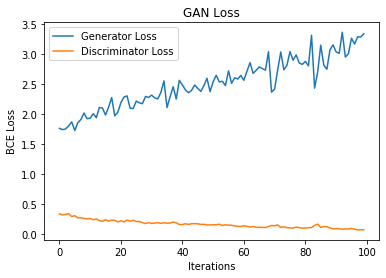

In [34]:
g1.plot_loss()

## Training our model on the full dataset with our GAN class

In [ ]:
# WARNING: Big dataset is huge, so should use fewer epochs
hp2 = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, 
                     output_dir="../generated_imgs",
                     lr=0.0002, beta1=0.5, epochs=10, batch_sz=64)
big_dataset = get_data_loader("../data/img_align_celeba/")
g2 = GAN(hp2)
g2.fit(big_dataset)

Loading weight ../discriminator_trained_weights/gnet_epoch_99_iter_0.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_epoch_99_iter_0.pt for Generator


  0%|          | 0/10 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 5.247557163238525
Generator Loss at epoch: 0, iter 0 = 2.0506749153137207
Discriminator Loss at epoch: 0, iter 10 = 1.515386939048767
Generator Loss at epoch: 0, iter 10 = 2.3940327167510986
Discriminator Loss at epoch: 0, iter 20 = 2.300029993057251
Generator Loss at epoch: 0, iter 20 = 2.831777572631836
Discriminator Loss at epoch: 0, iter 30 = 1.5384464263916016
Generator Loss at epoch: 0, iter 30 = 2.732119560241699
Discriminator Loss at epoch: 0, iter 40 = 1.167539358139038
Generator Loss at epoch: 0, iter 40 = 3.831724166870117


### Plotting its loss function

In [ ]:
g2.plot_loss()